# Calcul des coefficients des 5 fonctions de transferts

Executer tous les codes de la partie Initialisation. 
\
Les parties "Sratégie k" sont indépendantes et peuvent être éxecutées ou non.

## Initialisation

In [12]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


J'ai un modifié pred pour qu'elle puisse fonctionner pour n'importe quel degré de fonction de transfert

In [13]:
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares

#b = [2,1]       # numerateur
#a = [1,0.5,1]     # denominateur

#H_1 = sig.lti(b,a)

from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares

#b = [2,1]       # numerateur
#a = [1,0.5,1]     # denominateur

#H_1 = sig.lti(b,a)

def pred(x, t_e, entree):
    """
    Gives the response of a LTI system
    - at times t_e 
    - given an imput signal entree
    - given coefficients x
    """
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    """ Computes the squared error between truth and prediction """
    return (pred(x, t, entree) - y)**2

def err_multi(x, times, entrees, outputs):
    """ Computes the squared error between truth and prediction at multiple times """
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def RMSE(real,prediction):
    """ Computes the mean squared error between truth and prediction """
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

def err_mean(x, t, entree, y):
    return np.mean(err(x,t,entree,y))


def err_multi_ponde(x,times, entrees, outputs, poids):
    error = 0
    for k in range(len(entrees)) :
        error += poids[k]*np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 



In [14]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
    
columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']

In [15]:
columns_titles = ['Time','Output1','Input','Output2','Output3','Output4','Output5']
#columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']

for name in names:
    d[name].columns = columns_titles
    d[name] = d[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]
    
d['input0']

,Time,Input,Output1,Output2,Output3,Output4,Output5
0,0.000,0.0,-2.464122e-07,0.500000,0.500000,1.011923,1.009830
1,0.001,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
2,0.002,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
3,0.003,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
4,0.004,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
...,...,...,...,...,...,...,...
10231,10.231,0.0,4.889346e-01,0.346165,0.636405,0.603184,1.387077
10232,10.232,0.0,4.874977e-01,0.346696,0.635954,0.604425,1.385976
10233,10.233,0.0,4.860656e-01,0.347225,0.635506,0.605663,1.384878
10234,10.234,0.0,4.846381e-01,0.347751,0.635059,0.606896,1.383784


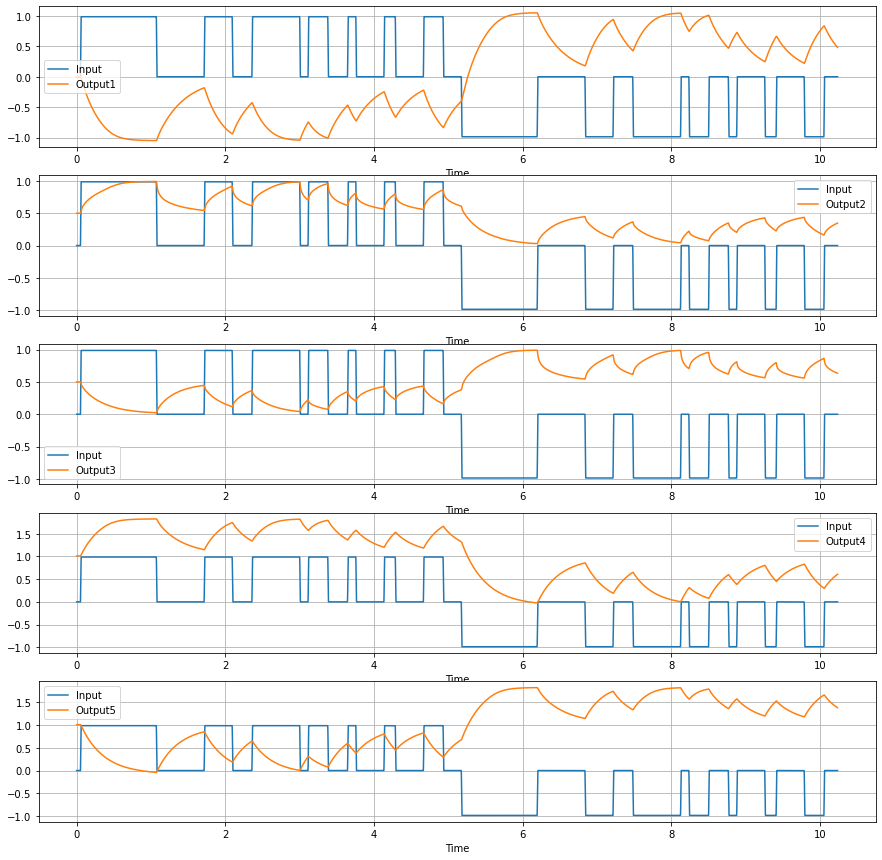

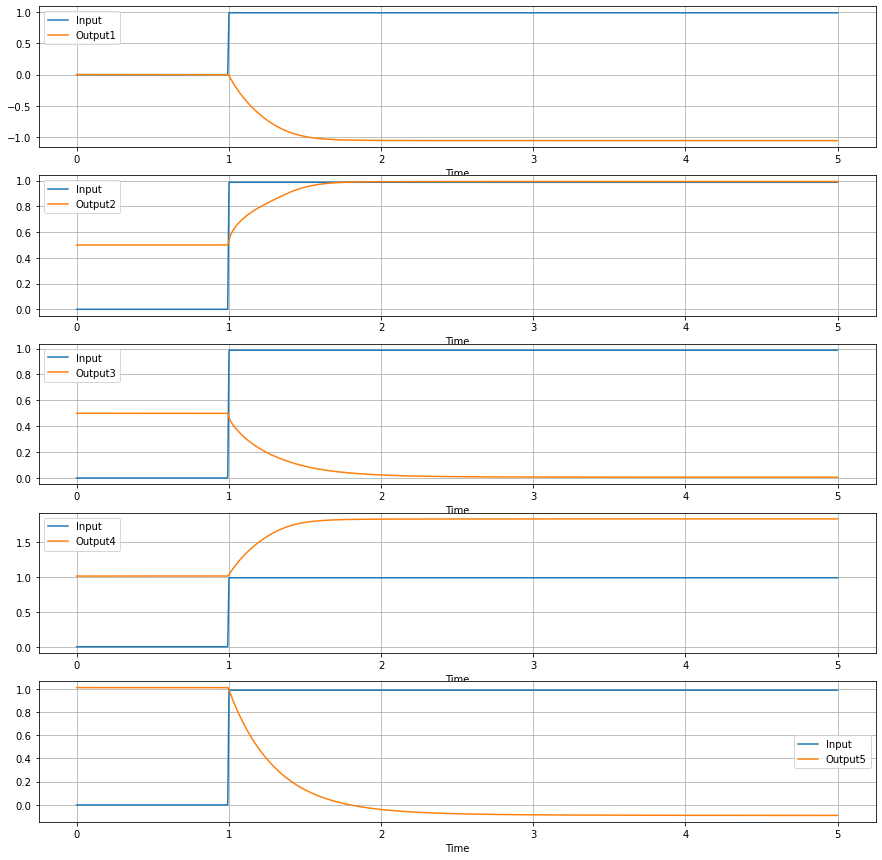

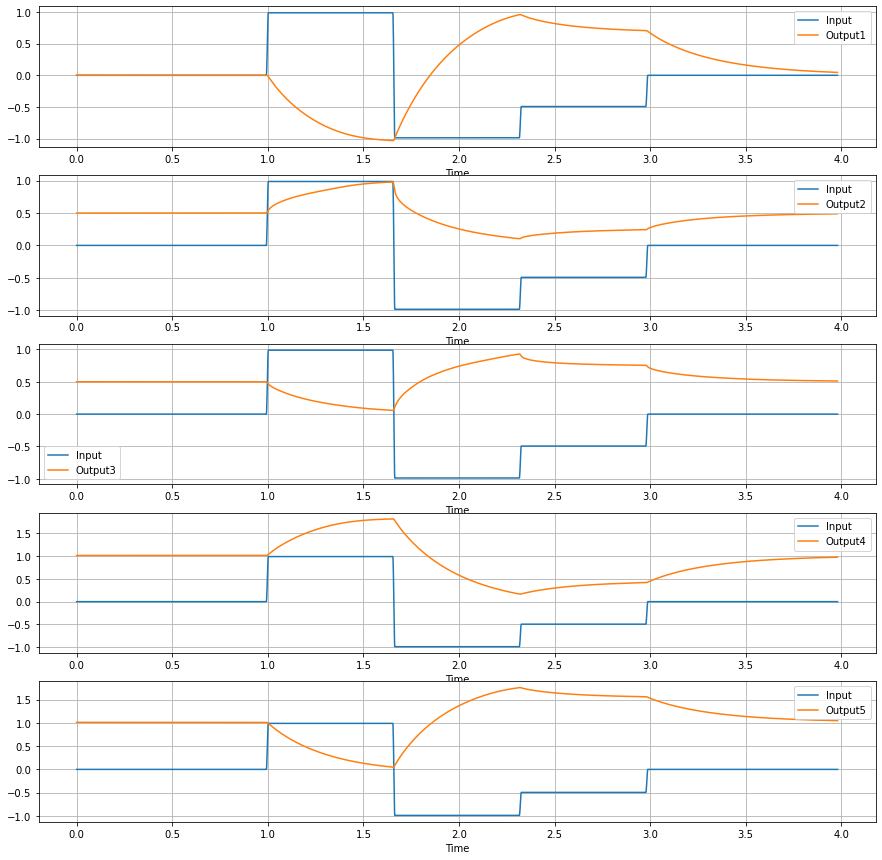

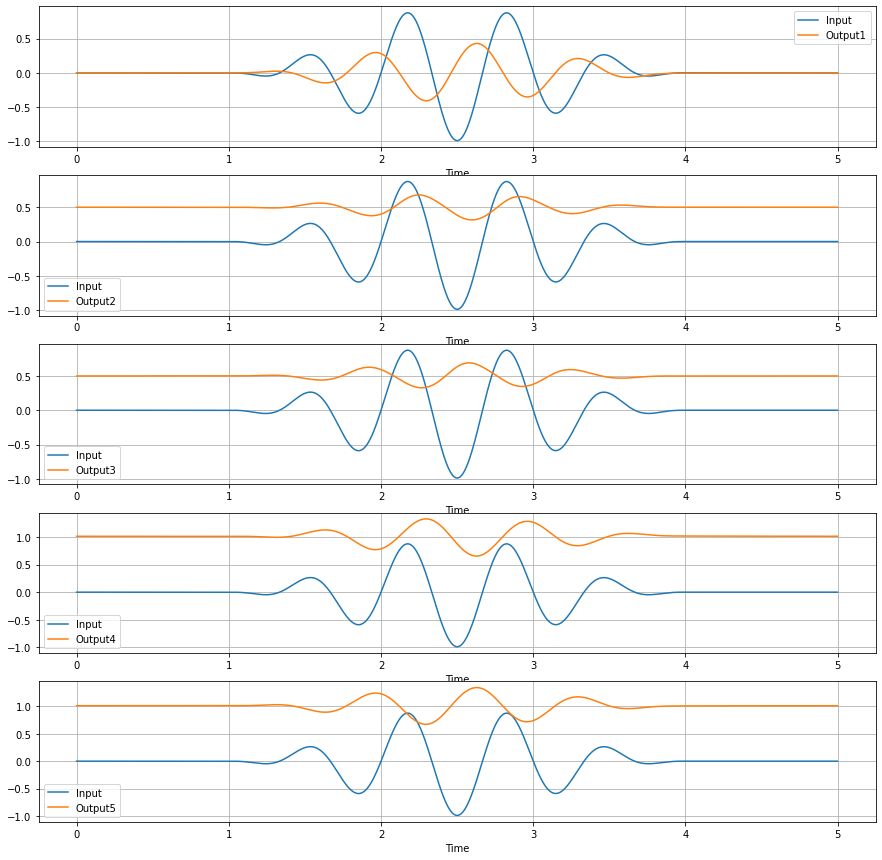

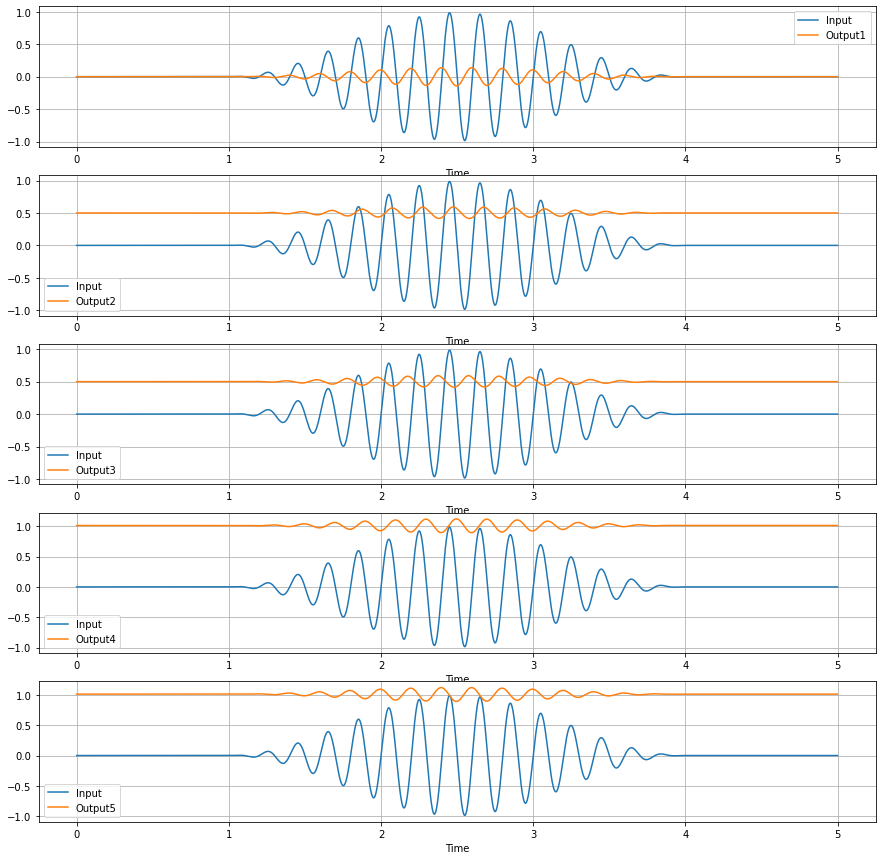

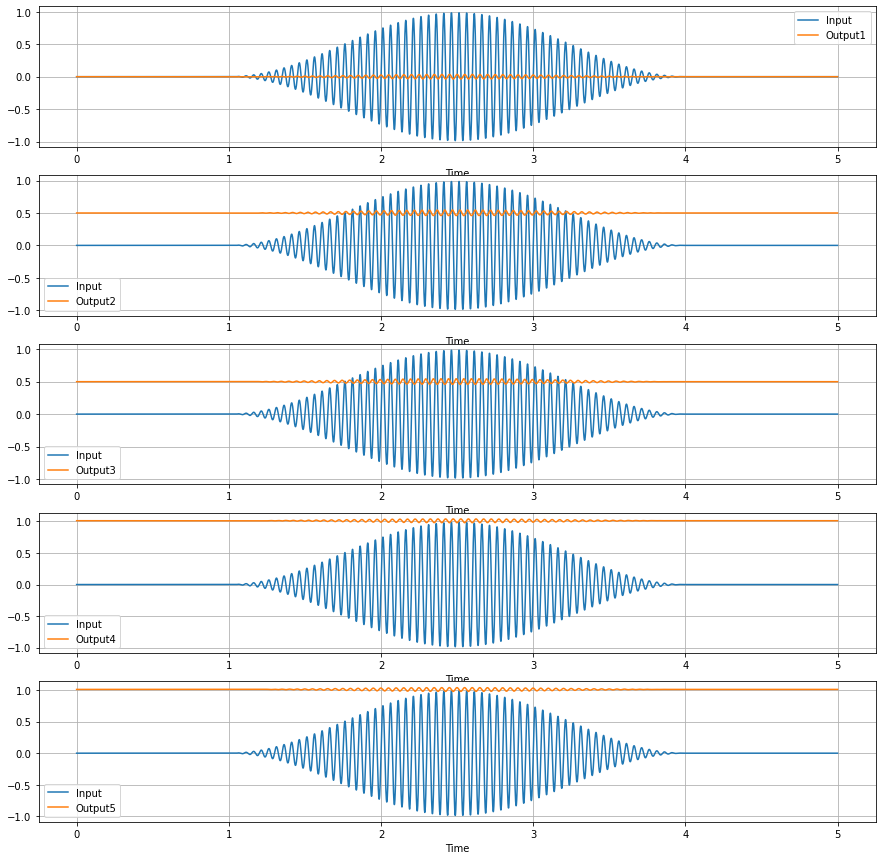

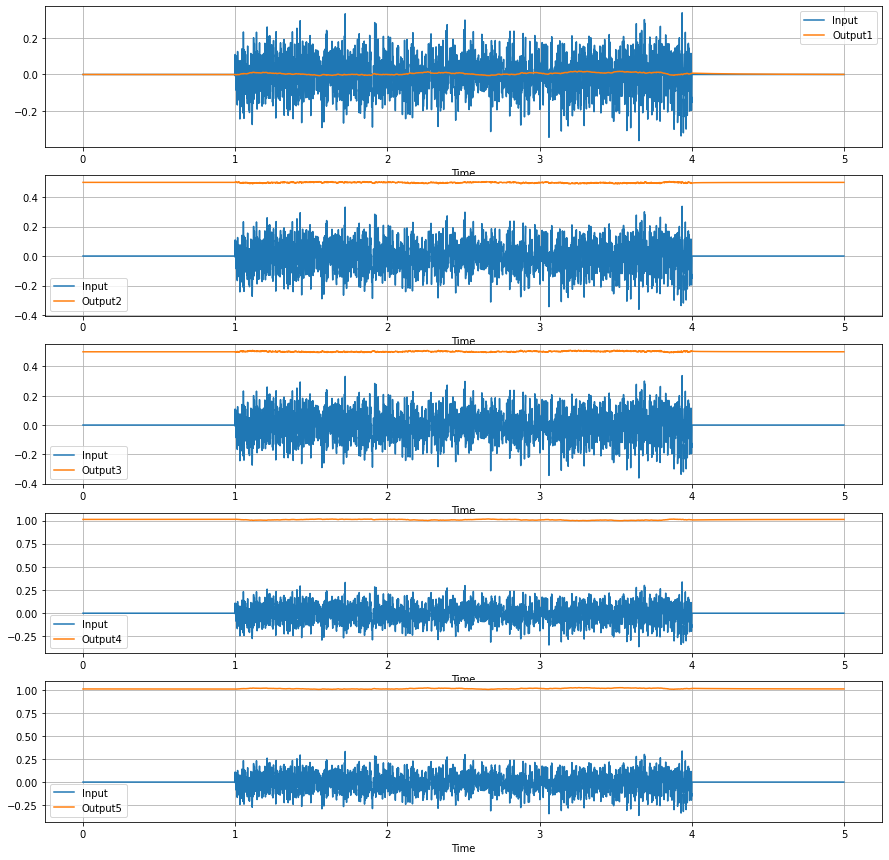

In [16]:
##Tracé des inputs et des outputs

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

In [17]:
##Calcul des shrink (positif ou négatif) et des offset de chaque output

Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

In [18]:
###Traitement des output
   
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

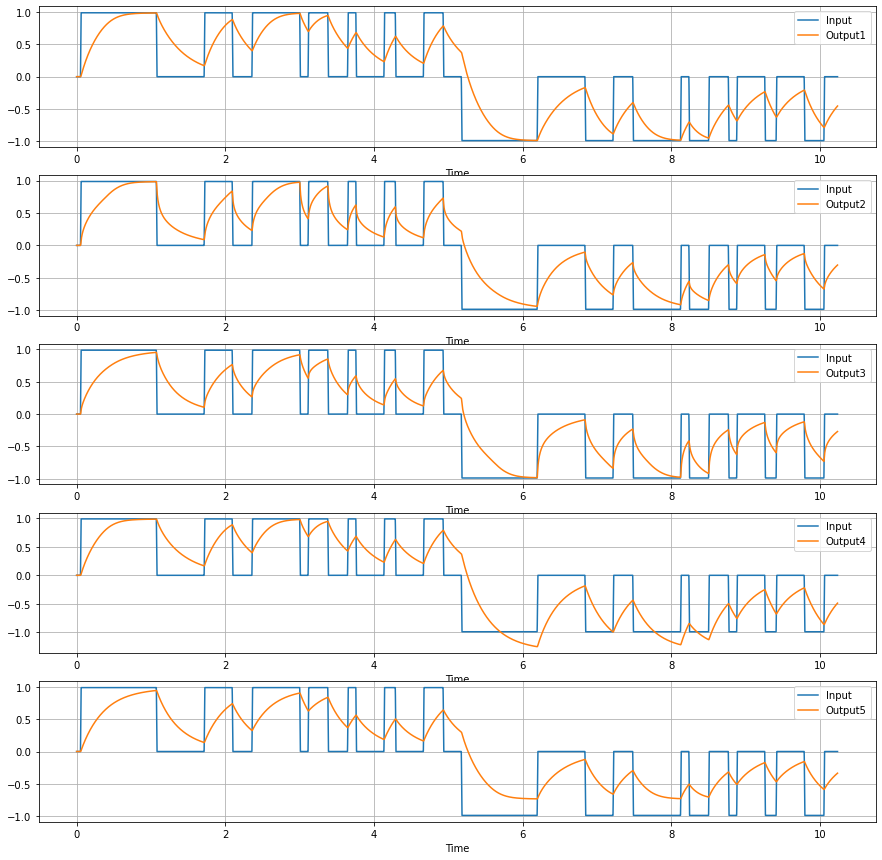

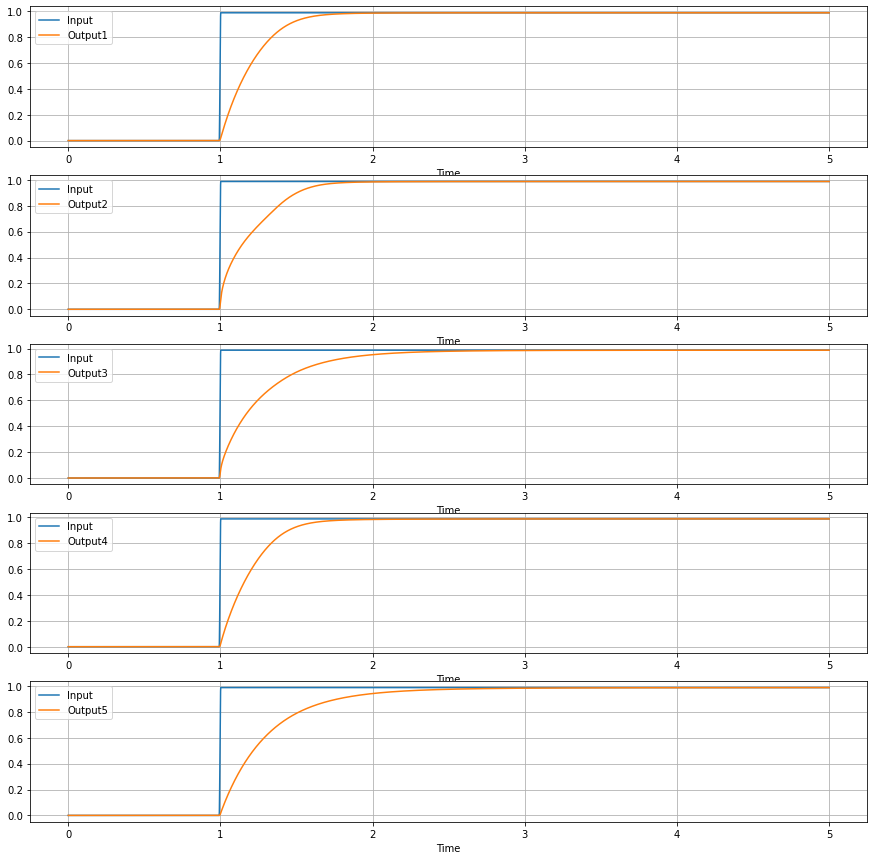

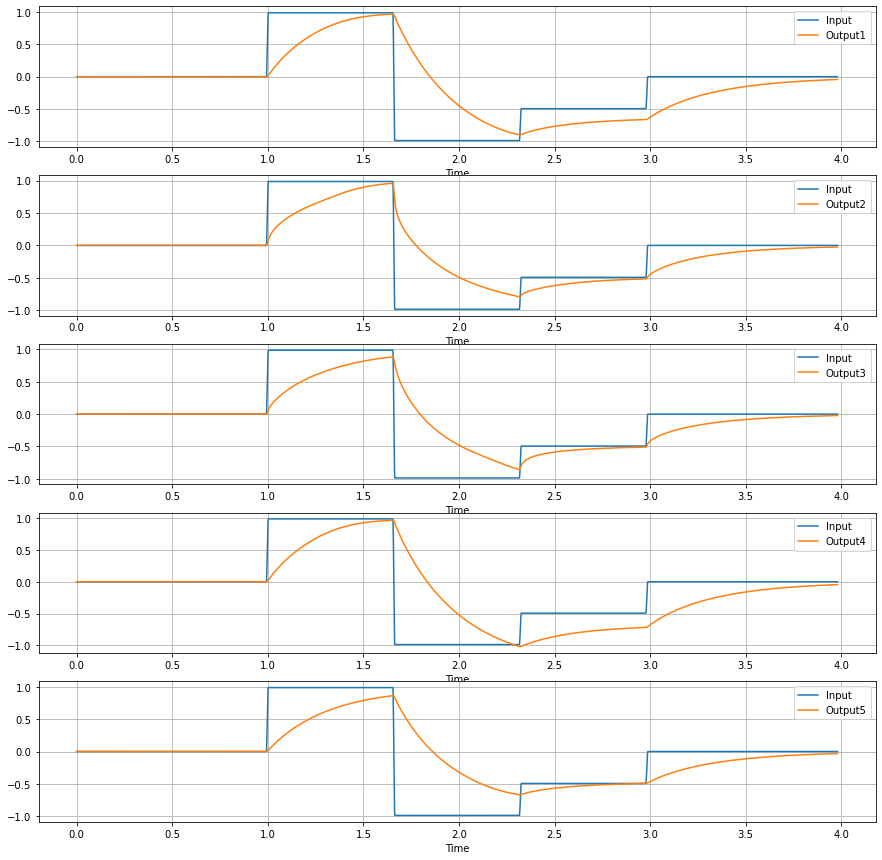

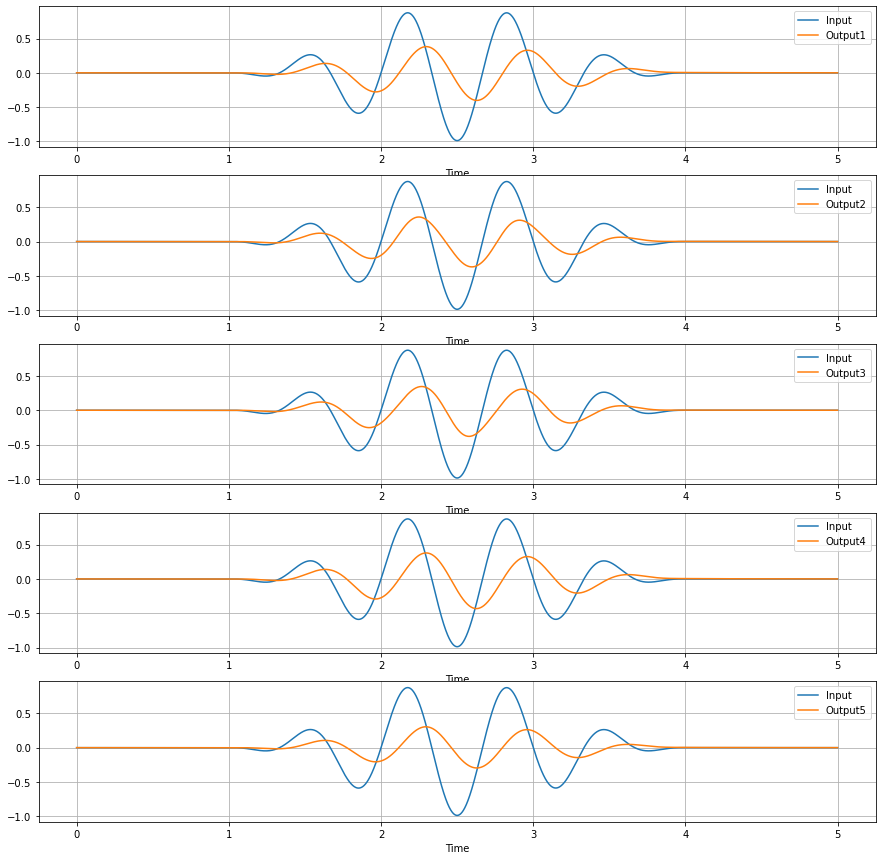

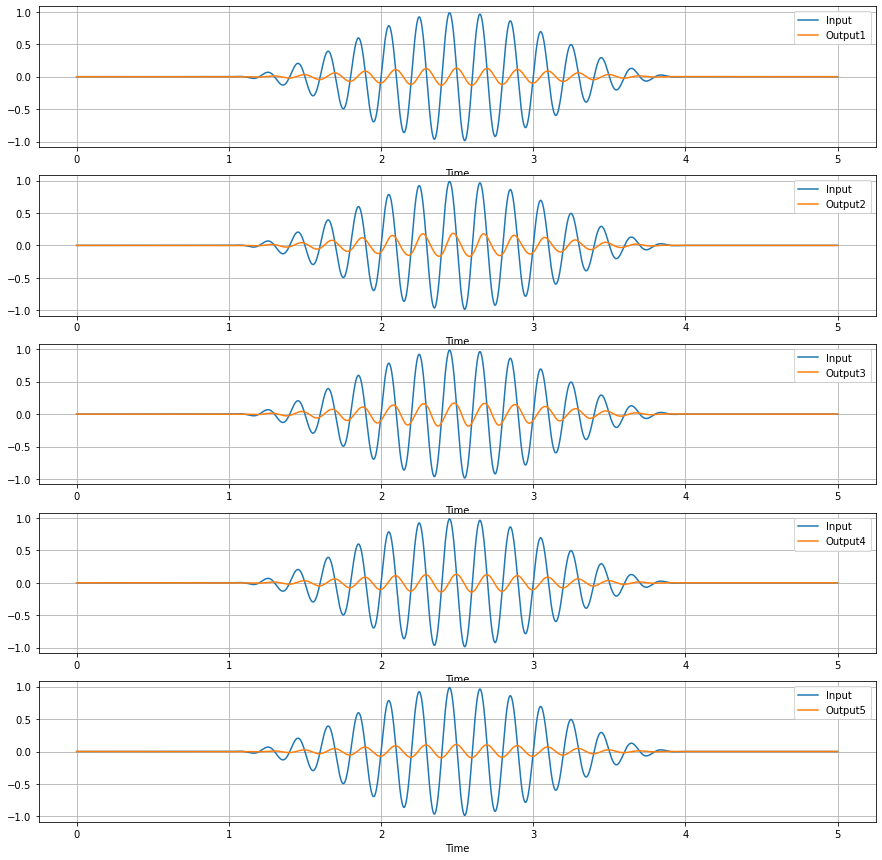

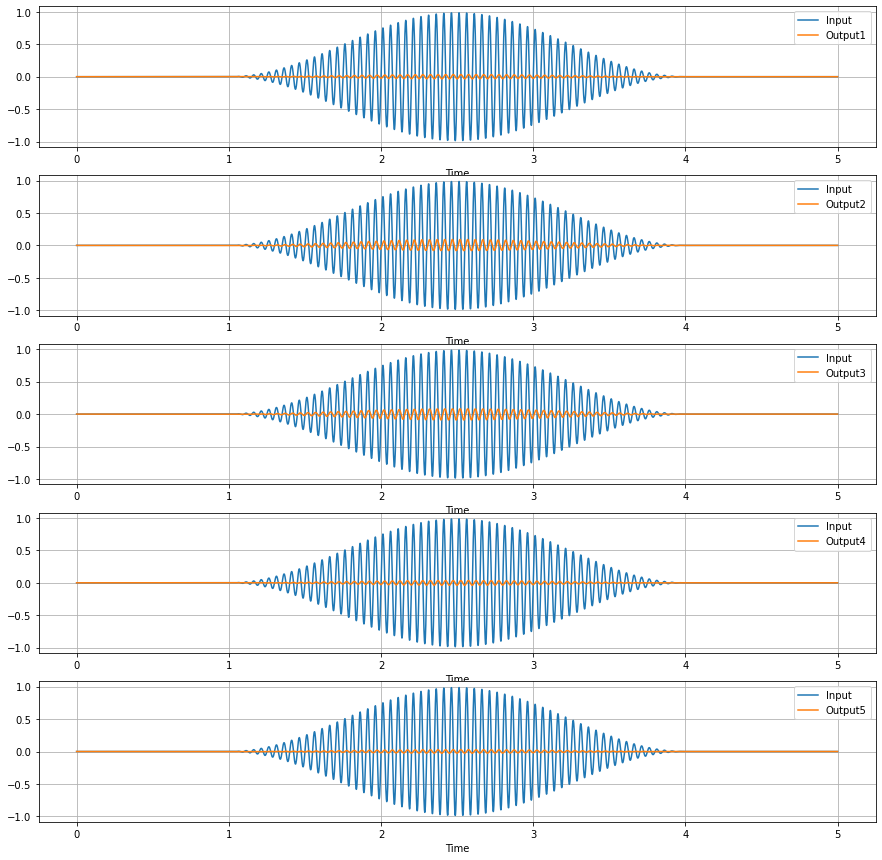

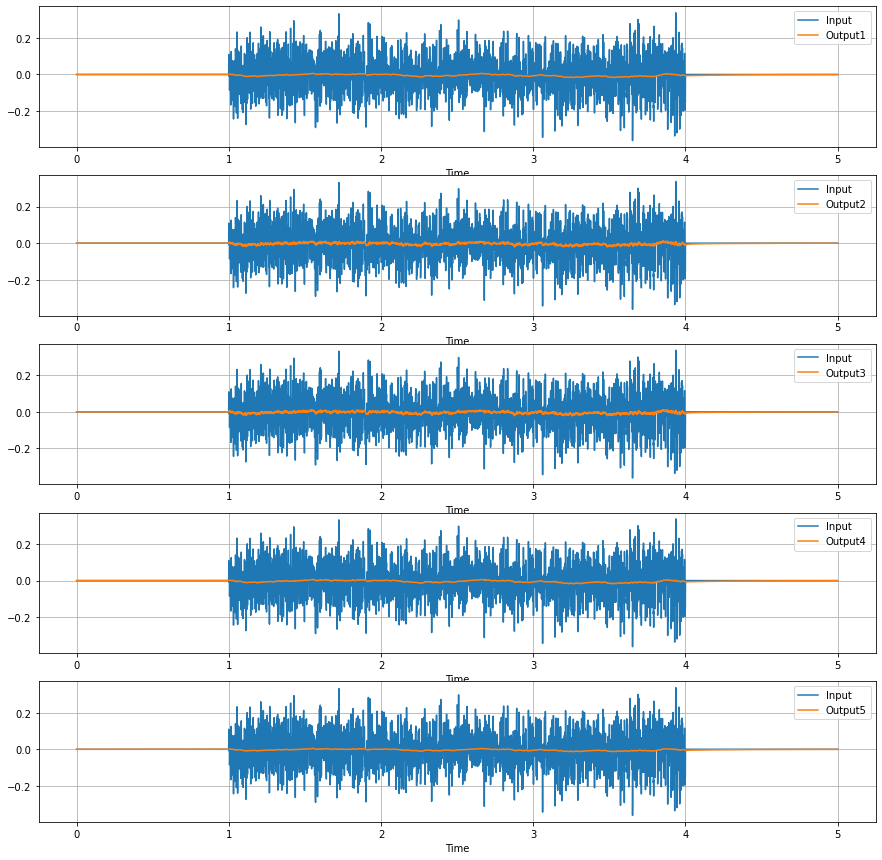

In [19]:
##Tracé des inputs et des Outputs corrigés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

## Stratégie 1 : Calcul des coefficients en minimisant l'erreur d'un seul input

Pour cette stratégie, l'entrainement sur l'input0 est bien plus efficace que les autres. Par ailleurs elle est plus rapide, on peut tester avec des degrés plus élevés pour la fonction de transfert.

In [20]:
##Calcul des coefficient avec un seul input

input_train = "input0"
params_output = {}
Compteur = 0
N_total = len(Output_names)
degre = 3

for name in Output_names:
    
    Time = d[input_train]['Time']
    Input = d[input_train]['Input']
    Output = d_corrige[input_train][name]
    
    ##Calcul des paramètre à un degré donné
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err, x0, bounds=(-3, 3), args=(Time,Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
    x = res.x
    
    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

    params_output[name] = x

Avancement : 20%
Avancement : 40%
Avancement : 60%
Avancement : 80%
Avancement : 100%


In [21]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties[key][name+"_approx"] = sortie
    
    Sorties[key] = pd.DataFrame(Sorties[key])

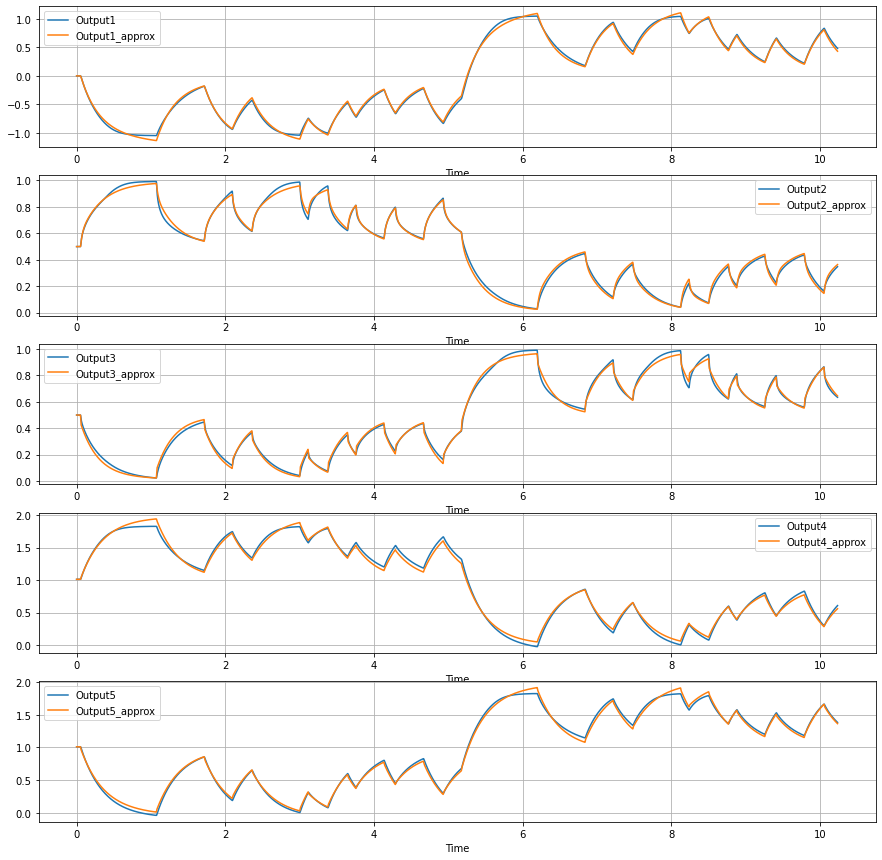

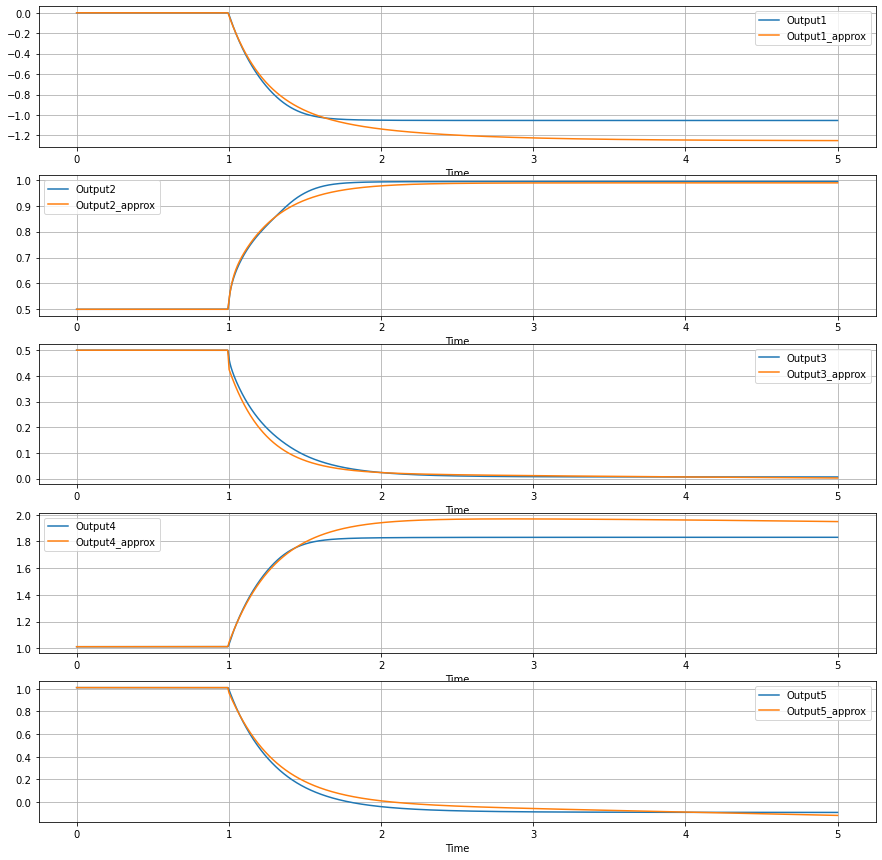

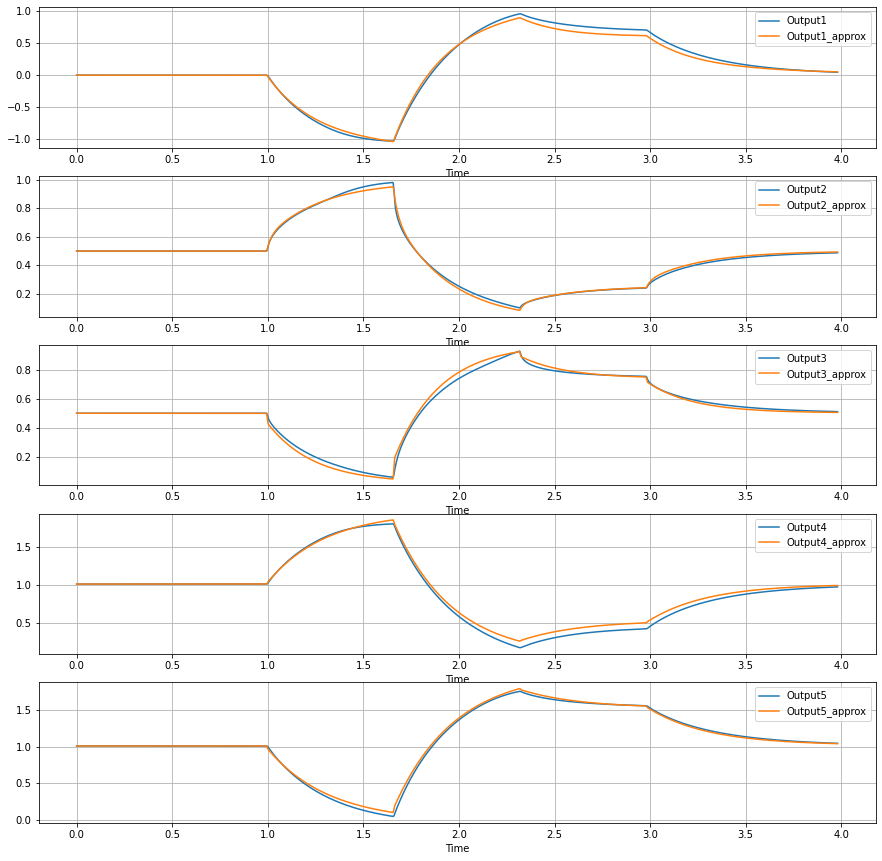

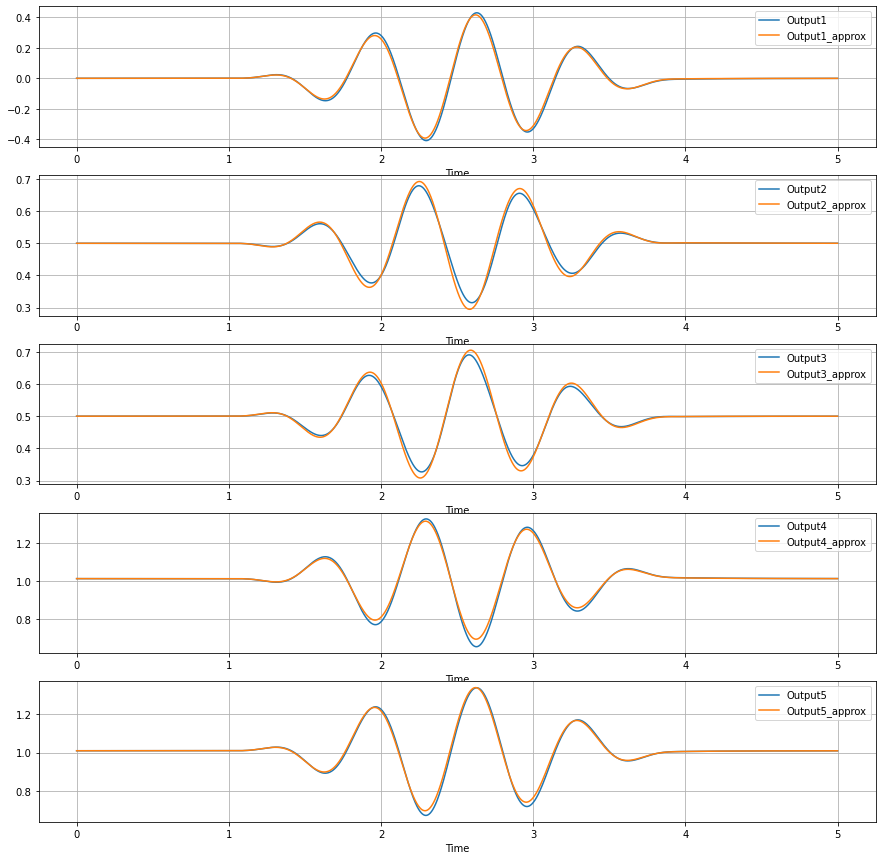

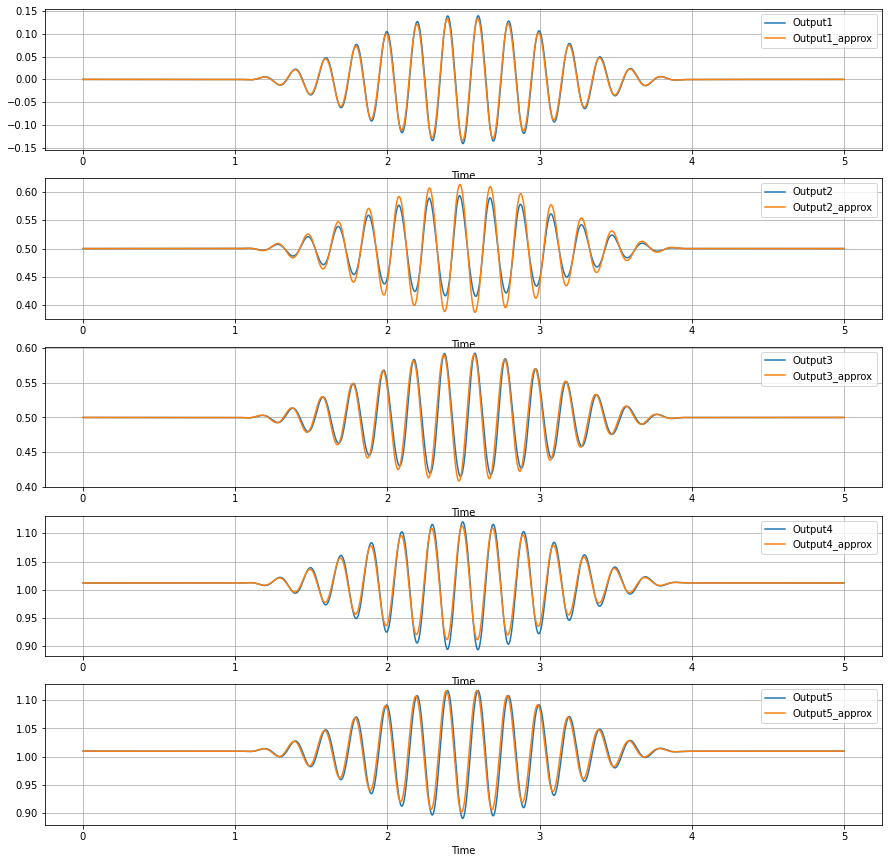

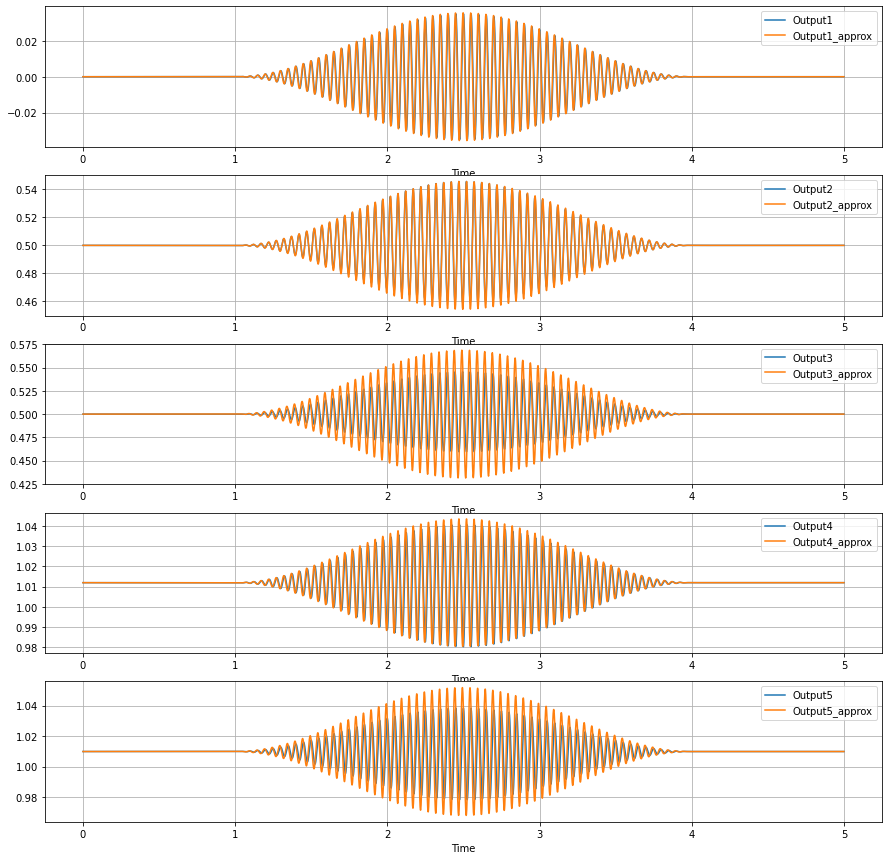

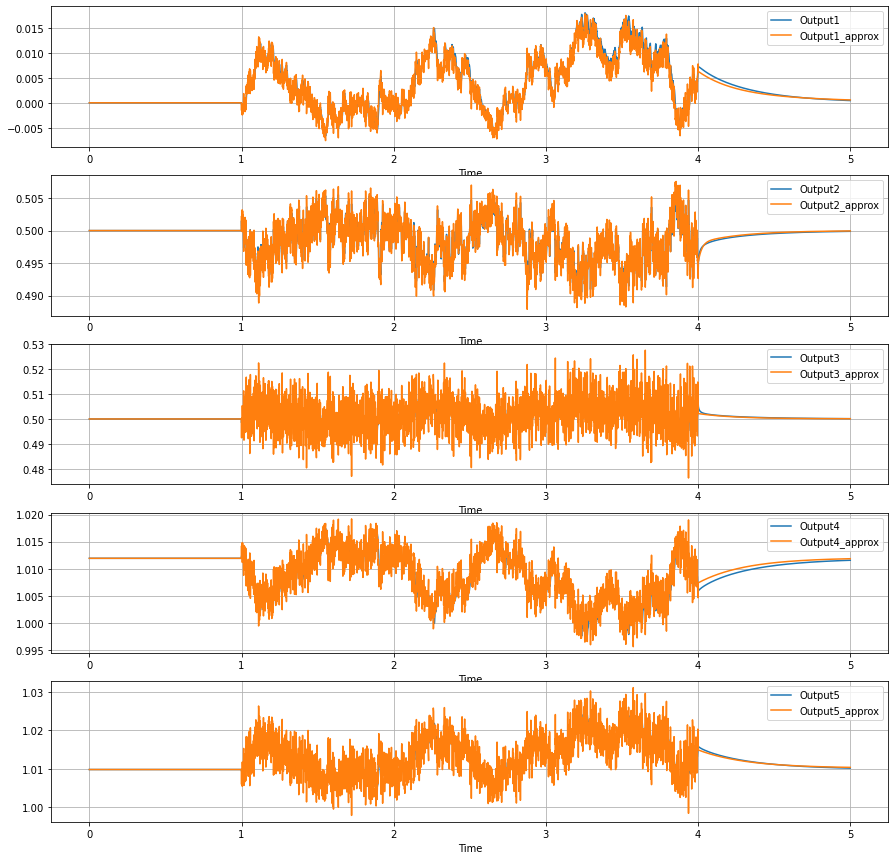

In [22]:
##Tracé des outputs et des outputs approximés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [23]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name == input_train)/(5*1)
        mean_rmse_test += rmse*(name != input_train)/(5*6)
        mean_rmse += rmse/(5*7)
        print(name)
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name == input_train))
        print("-----------------")
        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

input0
RMSE pour input0 et Output1 : 0.0009893865209580888
Input d'entrainement : True
-----------------
input0
RMSE pour input0 et Output2 : 0.0003709605278380324
Input d'entrainement : True
-----------------
input0
RMSE pour input0 et Output3 : 0.000395470271792916
Input d'entrainement : True
-----------------
input0
RMSE pour input0 et Output4 : 0.0018744058831720758
Input d'entrainement : True
-----------------
input0
RMSE pour input0 et Output5 : 0.0012557125681734106
Input d'entrainement : True
-----------------
input1
RMSE pour input1 et Output1 : 0.01860140598194495
Input d'entrainement : False
-----------------
input1
RMSE pour input1 et Output2 : 0.00010507499597865113
Input d'entrainement : False
-----------------
input1
RMSE pour input1 et Output3 : 0.00010140918117409212
Input d'entrainement : False
-----------------
input1
RMSE pour input1 et Output4 : 0.0108199026669807
Input d'entrainement : False
-----------------
input1
RMSE pour input1 et Output5 : 0.0008512159984700

## Stratégie 2 : Calcul des coefficients en minimisant l'erreur moyenne des inputs d'entrainement

Entrainement plus couteux en temps mais de meilleurs résultats à degré égal avec la stratégie 1.

In [ ]:
inputs_train = ['input0','input1','input3','input5']
inputs_test = ['input2','input4','input6']

entrees_train = [d[key]['Input'] for key in inputs_train]
times_train = [d[key]['Time'] for key in inputs_train]
params_output_2 = {}
degre = 4
N_total = len(Output_names)
Compteur = 0

for name in Output_names:
    outputs = [d_corrige[key][name] for key in inputs_train]
    
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err_multi, x0, bounds=(-3, 3), args=(times_train,entrees_train,outputs), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 50)
    x = res.x

    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) +"%")
        
    params_output_2[name] = x

In [ ]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties_v2 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_2[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v2[key][name+"_approx"] = sortie
    
    Sorties_v2[key] = pd.DataFrame(Sorties_v2[key])

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon d'entrainement

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_train:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_test:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name in inputs_train))
        print("-----------------")

        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

## Stratégie 3 : Agrégation fixe des coefficients selon la similitude entre les inputs

Ici on aura des coefficients pour chacun des inputs pour une fonction de transfert donnée (un indice d'output), donc $N_{outputs}\times N_{inputs}$.
\
On définit des paramètres pour classifier les inputs

In [ ]:
def calcul_frequence(Time,Input):
    
    frequence = 0
    t_0 = 0
    t_0_updated = 0
    t_1 = 0
    t_1_updated = 0
    
    ##calcul t_0 : premier instant input non nul
    k=0
    while t_0_updated == 0:
        if (Input[k]!=0):
            t_0 = Time[k]
            t_0_updated = 1
        k += 1
            
    ##calcul t_1 : dernier instant input non nul
    k=len(Time)-1
    while t_1_updated == 0:
        if (Input[k]!=0):
            t_1 = Time[k]
            t_1_updated = 1
        k -= 1
    
    ##calcul fréquence
    for k in range(2,len(Time)):
        if (Input[k]*Input[k-1]<=0) and (Input[k-1]*Input[k-2]>0):
            frequence += 1
    frequence = frequence/(t_1-t_0)
    
    
    return frequence

def calcul_lipschitz(Time,Input):
    max_L = 1
    L = 1
    Time_step = Time[1]-Time[0]
    for k in range(len(Time)-1):
        L = np.abs(Input[k+1]-Input[k])/np.abs(Time_step)
        if L > max_L :
            max_L = L    
    return max_L    

In [ ]:
def calcul_params_inputs(dic):
    params_inputs = {}
    moyenne_lip = 0
    moyenne_freq = 0    
    for inp in dic.keys():
        Time = dic[inp]['Time']
        Input = dic[inp]['Input']
        params_inputs[inp] = [] ##[lip,freq]
        lip = calcul_lipschitz(Time,Input)
        freq = calcul_frequence(Time,Input)
        params_inputs[inp].append(lip)
        params_inputs[inp].append(freq)
        moyenne_lip += lip/len(dic)
        moyenne_freq += freq/len(dic)
    
    ##normalisation des params
    for inp in dic.keys():
        params_inputs[inp][0] = params_inputs[inp][0]/moyenne_lip
        params_inputs[inp][1] = params_inputs[inp][1]/moyenne_freq
        
    return params_inputs

In [ ]:
inputs = ['input0','input1','input2','input3','input4','input5','input6']
dic = {}
for key in inputs:
    dic[key] = d[key]
params_inputs = calcul_params_inputs(dic)
params_inputs

In [ ]:
from sklearn.metrics import mean_absolute_error
from numpy import linalg as la
##grande similitude : signaux proches

def similitude(time,signal1,signal2):
    length = min([len(signal1),len(signal2)])
    return 1/max([1e-15,RMSE(signal1[:length-1],signal2[:length-1])])

def similitude_variations(time,signal1,signal2):
    length = len(time)
    derivative_signal1 = []
    derivative_signal2 = []
    time_step = time[1]-time[0]
    
    for k in range(length-2):
        derivative_signal1.append((signal1[k+1]-signal1[k])/time_step)
        derivative_signal2.append((signal2[k+1]-signal2[k])/time_step) 
    
    return 1/max([1e-15,RMSE(derivative_signal1,derivative_signal2)])

def similitude_variations2(time,signal1,signal2):
    length = len(time)
    derivative_signal1 = []
    derivative_signal2 = []
    time_step = time[1]-time[0]
    
    for k in range(1,length-2):
        derivative_signal1.append((signal1[k+1]-2*signal1[k]+signal1[k+2])/time_step**2)
        derivative_signal2.append((signal2[k+1]-2*signal1[k]+signal1[k+2])/time_step**2) 
    
    return 1/max([1e-15,RMSE(derivative_signal1,derivative_signal2)])

def similitude_moyenne(time,signal1,signal2):
    sim1 = similitude(signal1,signal2)
    sim2 = similitude_variations(time,signal1,signal2)
    sim3 = similitude_variations2(time,signal1,signal2)
    return 1/max([1e-15,np.mean([sim1,sim2,sim3])])

def similitude_MAE(time,signal1,signal2) :
    length = min([len(signal1),len(signal2)])
    return 1/max([1e-15,mean_absolute_error(signal1[:length-1],signal2[:length-1])])

def similitude_frequence(time,signal1,signal2):
    freq1 = calcul_frequence(time,signal1)
    freq2 = calcul_frequence(time,signal2)
    return 1/max([1e-15,np.abs(freq1-freq2)])

def similitude_generale(poids,param1,param2):
    param_1 = np.array(param1)
    param_2 = np.array(param2)
    
    params_dif = param_1-param_2
    params_dif_norme = np.array([np.abs(param) for param in params_dif])
    norme = np.dot(poids,params_dif_norme)
    
    return 1/max([1e-15,norme])

In [ ]:
##Coefficients pour chacun des inputs

inputs = d.keys()

params_output_3 = {}
for name in Output_names : 
    params_output_3[name] = {}
    
degre = 3
N_total = len(Output_names)*len(inputs)
Compteur = 0

for name in Output_names:
    for key in inputs :
        time = d[key]['Time']
        entree = d[key]['Input']
        output = d_corrige[key][name]

        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(time,entree,output), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 80)
        
        ##res = minimize(err_mean, x0, args=(time,entree,output), method = "BFGS")
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")

        params_output_3[name][key] = x

    params_output_3[name] = pd.DataFrame(params_output_3[name])

In [ ]:
params_output_3

Check des coefficients et suppression des valeurs absurdes/trop mauvaises

In [ ]:
###Calcul des outputs approximés

Sorties_v3_verif = copy.deepcopy(d)

    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    for name in Output_names :
        
        Time = d[key]['Time']
        Input = d[key]['Input']                       
        x = params_output_3[name][key]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
        Sorties_v3_verif[key][name+"_approx"] = sortie
        Sorties_v3_verif[key][name+"_approx"] = pd.DataFrame(Sorties_v3_verif[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")    
    

In [ ]:
##Tracé des outputs et des outputs approximés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3_verif[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

On évitera de train sur le bruit dans la suite

In [ ]:
###Calcul des output approximés en fonction des autres outputs avec similitude
inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = np.array([0.5,0.5])

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train]) ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

In [ ]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [ ]:
###RMSE pour les signaux de test

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0


for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon test : " + str(mean_rmse) )

### Recherche des poids optimaux dans le calcul de similitude


Fonction qui calcule l erreur moyenne globale de la methode similitude

In [ ]:
def erreur_moyenne_simi(poids,inputs,params_output,params_inputs,d):

    for key in inputs:
        for name in Output_names:
            Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))

    N_total = len(Output_names)*len(inputs)
    Compteur = 0

    for key in inputs:
        inputs_train = []
        for inp in inputs:
            if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

        for name in Output_names :
            similitudes_dic = {}
            for key_train in inputs_train:
                time1 = d[key]['Time']
                time2 = d[key_train]['Time']
                time = 0
                if len(time1) > len(time2) : time = time2
                else : time = time1
                similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train]) ##On choisit la mesure de similitude ici
            somme = sum(list(similitudes_dic.values()))

            for key_train in inputs_train:
                Time = d[key]['Time']
                Input = d[key]['Input']                       
                x = params_output[name][key_train]
                sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
                Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
            Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
            
    mean_rmse = 0
    N_outputs = 5

    for name in inputs:
        for k in range(N_outputs):
            rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
            mean_rmse += rmse*(name in inputs)/(5*len(inputs))
    
    return mean_rmse

In [ ]:
valeurs = np.linspace(0,1,10)

dimension_params = len(params_inputs["input0"]) ##nombre de paramètres

for i in range(len(valeurs)):
    poids = np.array([valeurs[i],1-valeurs[i]])
    e = erreur_moyenne_simi(inputs,params_output_3,params_inputs,d,poids)
    print(e, poids)

In [ ]:
x0 = [0.5,0.5]
x = np.arange(1,3)
res = least_squares(erreur_moyenne_simi, x0, args=(inputs,params_output_3,params_inputs,d), verbose=2, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 15)
res.x       